# <font color=darkblue>Variational Auto Encoders (using Jax) </font>



## <font color=darkred> Bibliography & additional ressources </font>

- [1]"An introduction to variational autoencoders", Kingma, D.P. et al., https://arxiv.org/abs/1906.02691
``Easy to read overview with practical considerations``.
- [2] https://keras.io/examples/timeseries/timeseries_anomaly_detection/ ``toy autoencoder model to detect anomalies in timeseries data``
- [3] https://www.sciencedirect.com/science/article/pii/S0378778821009075
``Energy disaggregation using variational autoencoders``
- [4] https://github.com/najeebuddinm98/vae_fashionmnist/blob/main/VAE_fashionmnist.ipynb
``For the toy Keras implementation``
- [5] https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb
``For the toy Torch implementation``

## <font color=darkred>Rationale on variational inference, encoders and decoders</font>


The framework of variational autoencoders (VAEs) (Kingma and Welling,
2014; Rezende et al., 2014) provides a principled method for jointly
learning deep latent-variable models and corresponding inference models
using stochastic gradient descent.

Consider random variables $(Z,X)$ in $\mathbb{R}^d\times \mathbb{R}^m$ where $X$ is the observation and $Z$ is not observed. Assume that the distribution of $(Z,X)$ has a density $(z,x)\mapsto p_\theta(z,x)$ with respect to the Lebesgue measure. In this framework, we write
$$
(z,x)\mapsto p_\theta(z,x) = p_\theta(z)p_\theta(x|z)\,,
$$
where $z\mapsto p_\theta(z)$ is a prior density for $Z$ and $x \mapsto p_\theta(x|z)$ is the likelihood of $X$ given $Z$. We **do not** have access to the conditional distribution of $Z$ given $X$ in general as:
$$
z\mapsto p_\theta(z|x) = \frac{p_\theta(z)p_\theta(x|z)}{p_\theta(x)}\,,
$$
where $p_\theta(x) = \int p_\theta(z)p_\theta(x|z) \mathrm{d} z$ is an intractable integral.

**Example 1**.
Deep latent variable model for multivariate Benoulli data. In this setting, $X\in\{0,1\}^D$ and conditionally on a variable $Z\in\mathbb{R}^d$, $(X_1,\ldots,X_D)$ are independent with Bernoulli distribution with parameters ${\bf p}_\theta(Z) = (p_{1,\theta}(Z),\ldots, p_{D,\theta}(Z))$, where ${\bf p}_\theta(Z) $ is the output of a Multi-layer Perceptron with input $Z$ and parameters $\theta$ (weights and biases). In this example, the input variable has a prior distribution $Z\sim \mathcal{N}(0,I_d)$ and, for any value of $\theta$, the conditional distribution of $Z$ given $X$ is not available explicitly.

In varitional inference, we introduce a family of possible candidate distributions to approximate $z\mapsto p_\theta(z|x)$. Consider $\mathcal{D} = \{q_\phi\}_{\phi\in\Phi}$ where $\Phi$ is a parameter space and where  $q_\phi$ are chosen so that:

  - for all $\phi$, $q_\phi$ is easy to evaluate ;
  - for all $\phi$, $q_\phi$ is easy to sample.


The distribution $p_\theta(x|z)$ is referred to as the **decoder**. This is the distribution used to **reconstruct data from encoded vectors**.

The distribution $q_\varphi(z|x)$ is referred to as the **encoder**. This is the distribution used to **encode complex data in a simple latent space**.

*Illustration from [1]*.

![](https://d3i71xaburhd42.cloudfront.net/329b84a919bfd1771be5bd14fa81e7b3f74cc961/22-Figure2.1-1.png)

*From https://www.researchgate.net/figure/Our-proposed-CNN-autoencoder-architecture-for-detecting-anomalies-in-time-series-data_fig1_339163784*

![](https://www.researchgate.net/profile/Stefania-Russo-7/publication/339163784/figure/fig1/AS:857232916897792@1581391662375/Our-proposed-CNN-autoencoder-architecture-for-detecting-anomalies-in-time-series-data.png)

**Example 2**
Example from [3] which introduced a non-intrusive load monitoring (NILM) and energy disaggregation approach based on the variational autoencoders. The consumption of **individual appliances can be estimated from the aggregate measurement**.  The probabilistic encoder makes this approach an efficient model for encoding information relevant to the reconstruction of the target appliance consumption (complex load profiles, multi-state appliances).

The input and output sequences are obtained using a **sliding window**. Each input sequence $\tilde x = (\tilde x_1,\ldots,\tilde x_T)$ is processed separately by the model to generate an output sequence $x = (x_1,\ldots,x_T)$ corresponding to the power of the target appliance. We build a conditional model $p_\theta(x|z,\tilde x)$ using a conditional variational distribution $q_\varphi(z|x,\tilde x)$.

``From [3]``
![](https://ars.els-cdn.com/content/image/1-s2.0-S0378778821009075-gr1.jpg)

## <font color=darkred>ELBO and loss function</font>


For all $x$ and all $\phi$,
\begin{align*}
\mathrm{KL}\left(q_\phi(\cdot|x)\|p_\theta(\cdot|x)\right) = \int q_\phi(z|x) \log \frac{q_\phi(z|x)}{p_\theta(z|x)} \mathrm{d}z&= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z|x)]\,,\\
 &= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]+\log p_\theta(x)\,,\\
&= -\mathcal{L}(\theta,\phi,x)+\log p_\theta(x)\,,
\end{align*}
where $\mathcal{L}(\theta,\phi,x) = \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]$. Using Jensen's inequality, note that $\mathrm{KL}\left(q_\phi\|p_\theta(\cdot|x)\right) \geq 0$ so that
$$
\mathcal{L}(\theta,\phi,x)\leq \log p_\theta(x)\,.
$$
This motivates the name Evidence Lower Bound  (ELBO) of the surrogate quantity to be optimized. In variational inference,   $p_\theta(\cdot|x)$ is estimated by  $q_{\phi_*}$ where :
$$
(\theta_*\phi_*) \in \mathrm{argmax}_{\phi\in\Phi}\;\frac{1}{n}\sum_{i=1}^n\mathcal{L}(\theta,\phi,x_i)\,,
$$
with $(x_i)_{1\leq i \leq n}$ i.i.d. data from the dataset. In practice, $\mathcal{L}(\theta,\phi,x_i)$ cannot be computed and is replaced by a Monte Carlo estimate, i.e. we sample $Z_i\sim q_\phi(\cdot|x)$ and we compute:
$$
\widehat{\mathcal{L}}(\theta,\phi,x_i) = \log q_\phi(Z_i|x_i) - \log p_\theta(Z_i,x_i)\,.
$$

## <font color=darkred>Examples of simple implementations</font>

**Keras**
https://github.com/najeebuddinm98/vae_fashionmnist/blob/main/VAE_fashionmnist.ipynb

**Torch**
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb

## <font color=darkred>Jax mini tutorial</font>

A adapter (pas mini tuto mais VAE via JAX)

[Jax](https://github.com/google/jax) enables to use python and numpy functions with automatic gradient computation, and fast linear algebra through just in time (jit) compilation (see [XLA](https://www.tensorflow.org/xla)). It is specifically designed for **high-performance numerical computing and large-scale machine learning**.

- JAX can **automatically differentiate native Python and NumPy functions** (through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives).

- XLA is a linear algebra compiler which **accelerates TensorfFlow models** (fby 5 to 10 on large machine learning models).

- XLA compiles the TensorFlow graph in a sequence of computational kernels generated specifically for each model, and exploits **model-specific information for optimization**.

- From [XLA](https://www.tensorflow.org/xla): if we want to compute **tf.reduce_sum(x + y * z)**, in XLA, the graph launches **three kernels**: one for multiplication, one for addition and one for reduction. However, XLA can optimize the graph so that it calculates the result in a single kernel run. To do this, it merges the addition, multiplication and reduction operations into a single GPU kernel. What's more, this merged operation does not write the intermediate values generated by y*z and x+y*z to memory. Instead, it "broadcasts" the results of these intermediate calculations directly to users, while storing them in their entirety in GPU registers.


In [1]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


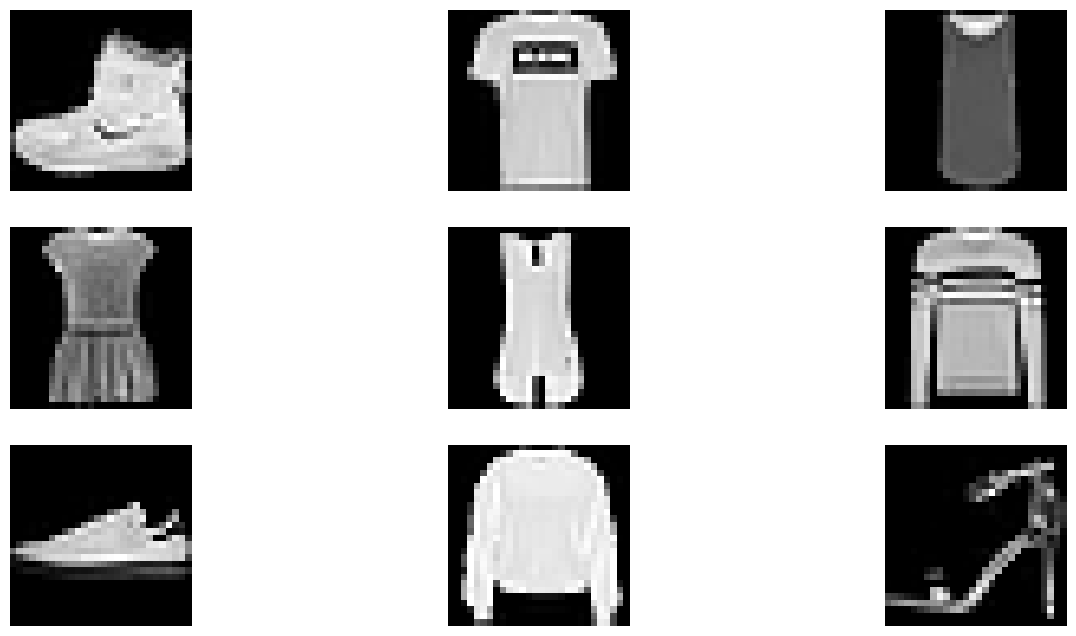

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(figsize=(16, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

((60000, 784), (10000, 784))

In [5]:
import jax
import jax.numpy as jnp
from jax import jit, grad

You may use jnp as you would use numpy normally, doing so will enable the autograd and the optimizations

In [8]:
W = jnp.zeros((2,3))
x = jnp.zeros((2))
jnp.dot(x, W)

Array([0., 0., 0.], dtype=float32)

### Random numbers with jax

In [9]:
from jax import random
rand_key = random.PRNGKey(1)

In Jax the random state when generating pseudo random numbers is not automatically updated (see https://github.com/google/jax/blob/master/design_notes/prng.md).
For example, run the following example several times and note that the same random numbers are generated.

Feeding the same key to a random function will always result in the same sample being generated

In [11]:
random.normal(rand_key, shape=(2,3))

Array([[ 0.95730704, -0.9699289 ,  1.0070665 ],
       [ 0.3661903 ,  0.1729483 ,  0.29092234]], dtype=float32)

To manually update the state (`rand_key` here), the usual practice is to use the `random.split` function, to get two new random keys. You may then update the state using one of them, and use the other for generation of random numbers.

In [17]:
k1, k2 = random.split(rand_key)

# Update rand_key
rand_key = k1
print(k1)

# Use k2
random.normal(k2, shape=(2,3))

[3930561465  127780745]


Array([[-0.17330456, -1.9292002 , -0.80252   ],
       [-0.7264247 , -1.0553217 , -0.8676762 ]], dtype=float32)

The rule of thumb is: **never reuse keys (unless you want identical outputs)**.

In order to generate different and independent samples, you must split() the key yourself whenever you want to call a random function.

## <font color=darkred>Building blocks of VAE</font>

### Building the Encoder

The inference model is defined as:

$$\mu_z(\mathbf{x}), \sigma_z(\mathbf{x}) = encoder_{\phi}(\mathbf{x})$$
$$q_\phi(z|x) = \mathcal{N}(z; \mathbf{\mu}_z, diag(\mathbf{\sigma}_z)) $$

We first build **$encoder_{\phi}$ as a MLP with a single hidden layer. Note that $\mu_z$ and $\sigma_z$ are $k$-dimensionnal where $k$ is the dimension of the latent space. For visualization purposes we choose $k = 2$**.

The following cells define the parameters $\phi$ (named here `params_enc`) as several weigth matrices and biases, that we initialize through standard initialization schemes, then the encoder function itself.

Note that in practice the output of the encoder network parameterizes $\log(\sigma^2_z(x))$ instead of $\sigma_z(x)$. Taking the exponential of $\log(\sigma^2_z(x))$ ensures the positivity of the standard deviation from the raw output of the network.

In [18]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu, Sigmoid

input_dim = x_train_standard.shape[-1]
hidden_dim = 128
latent_dim = 2

encoder_init, encoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(latent_dim * 2))

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_enc = encoder_init(rand_key, (-1, input_dim))

print("Parameters: (W,b) of first Dense, Relu, (W,b) of second Dense: ")
[[p.shape for p in param] for param in params_enc]

Parameters: (W,b) of first Dense, Relu, (W,b) of second Dense: 


[[(784, 128), (128,)], [], [(128, 4), (4,)]]

The use of `jit` enables just in time compilation which will strongly improve computation speed. The first time you run it, it will compile (and thus be slower), subsequent runs will be faster. You may check this by running the following cell several times with ctrl-enter.

See ``https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html``

In [20]:
%time z = jit(encoder_fn)(params_enc, x_train_standard[0:10])
%time z = encoder_fn(params_enc, x_train_standard[0:10])
print(f"\nShape of the output: {z.shape}")

CPU times: user 1.93 ms, sys: 905 µs, total: 2.83 ms
Wall time: 2.91 ms
CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 1.06 ms

Shape of the output: (10, 4)


### Reparametrization trick

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(z, \mu_z(x), diag(\sigma_z(x))) $$

The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

This is illustrated as follows (from Kingma 2015 Neurips):
<img src=https://i.stack.imgur.com/TzX3I.png alt="Reparametrization Trick" width="500"/>


In [21]:
def sample(rand_key, z_mean, z_log_var):
    epsilon = random.normal(rand_key, shape=z_mean.shape)
    return z_mean + jnp.exp(z_log_var / 2) * epsilon

fast_sample = jit(sample)

### Building a Decoder

We will build an architecture where the decoder is a MLP with a single hidden layer.

We first define the parameters $\theta$ (named here `params_dec`) as several weigth matrices and biases, that we initialize through standard initialization schemes.

In [22]:
decoder_init, decoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(input_dim), Sigmoid)

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_dec = decoder_init(rand_key, (-1, latent_dim))

params = params_enc + params_dec

### VAE Loss (negative ELBO)

We now plug the encoder and decoder via the stochastic latent variable $z$ to get the full VAE architecture. The loss function is the negative ELBO of the variational inference problem, the sum of two terms.

- **Crossentropy loss between the input and its reconstruction through the autoencoder**. We consider that the output of the decoder parametrizes a Bernoulli distribution. This assumes that the data is valued on $\{0,1\}$, which is not true in practice. This assumption will be questioned later.
- **KL divergence between the distributions of $z$ and the prior distribution** (centered Gaussian)

Intuitively, this corresponds to improving the likelyhood of the model, and making $q_\phi(z|x)$ match as closely as possible $p(z|x)$.

Note that we consider all parameters as an argument of the loss function, so that Jax is able to differentiate with regards to each of the parameters: `params = params_enc + params_dec`

In [23]:
EPSILON = 1e-6
negative_xent = jit(lambda x, y: - jnp.sum(y * jnp.log(x + EPSILON) +
                                           (1-y)*jnp.log(1-x + EPSILON), axis=-1))

negative_kl = jit(lambda z_mean, z_log_var: - 0.5 *
                  jnp.sum(1 + z_log_var - z_mean ** 2 - jnp.exp(z_log_var), axis=-1))

@jit
def vae_loss(rand_key, params, x):
    # Encoder
    latent = jit(encoder_fn)(params[0:3], x)
    d = latent.shape[-1]//2
    z_mean, z_log_var = latent[:, :d], latent[:,d:]

    # Sample
    z_sample = fast_sample(rand_key, z_mean, z_log_var)

    # Decoder
    x_rec = jit(decoder_fn)(params[3:], z_sample)

    xent_loss = negative_xent(x_rec, x)
    kl_loss = negative_kl(z_mean, z_log_var)

    # average over the batch, and sum kl / xent
    negative_elbo = jnp.mean(xent_loss) + jnp.mean(kl_loss)
    return negative_elbo

In [24]:
%time vae_loss(rand_key, params, x_train_standard[0:10])

CPU times: user 277 ms, sys: 8.04 ms, total: 285 ms
Wall time: 280 ms


Array(545.50214, dtype=float32)

### Autodiff in Jax

The `grad` operator in Jax takes a loss function, and computes automatically all differentiations, returning the gradient of the loss function with regards to the parameters, for a given input datapoint. Note the following syntax:

If `loss` is a function of parameters and input datapoint `loss = f(param, x)`, `grad(loss)` returns a new function, which takes the same input as `loss`: `grad(loss) = f_grad(param, x)`


Shapes of all gradients of the loss with regards to each parameter, for a batch of 1 inputs: 

[enc] (W,b) of first Dense : (784, 128) (128,)
[enc] Relu : 
[enc] W,b) of second Dense : (128, 4) (4,)
[dec] (W,b) of first Dense : (2, 128) (128,)
[dec] Relu : 
[dec] (W,b) of second Dense : (128, 784) (784,)
[dec] Sigmoid : 

Image, Gradients of the first dense, gradient of the last dense, summed for each pixel


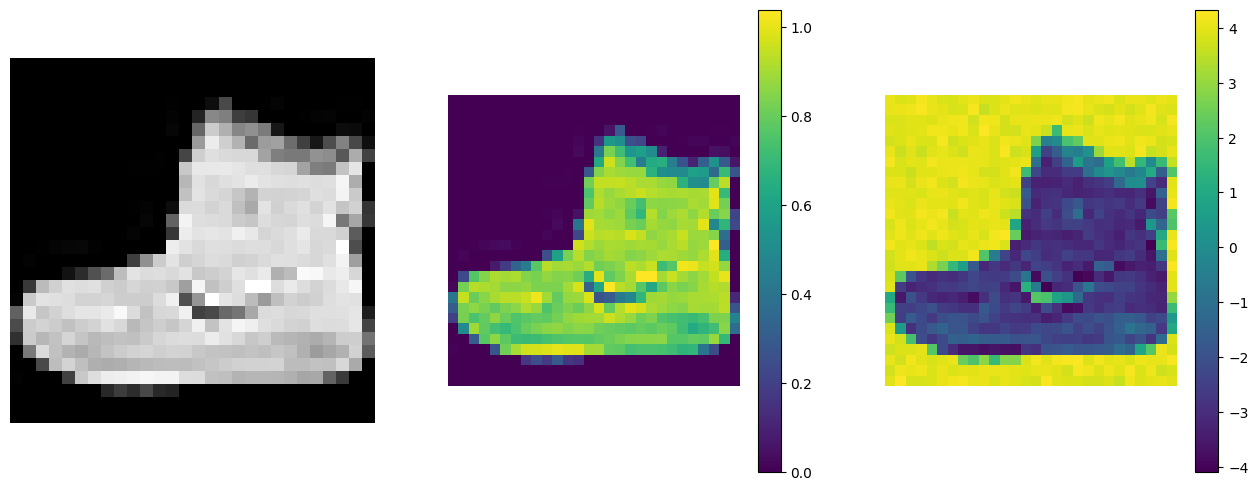

In [25]:
from functools import partial
rand_key, key = random.split(rand_key)
vae_loss_rand = partial(vae_loss, key) # this creates a function val_loss without the rand_key argument

grads = grad(vae_loss_rand)(params, x_train_standard[0:1])

print("Shapes of all gradients of the loss with regards to each parameter, for a batch of 1 inputs: \n")
names = ["[enc] (W,b) of first Dense", "[enc] Relu", "[enc] W,b) of second Dense",
         "[dec] (W,b) of first Dense", "[dec] Relu", "[dec] (W,b) of second Dense", "[dec] Sigmoid"]

print("\n".join([name + " : "+ " ".join([str(p.shape) for p in param]) for name, param in zip(names, grads)]))

print("\nImage, Gradients of the first dense, gradient of the last dense, summed for each pixel")
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap="gray");
plt.axis("off");
plt.subplot(1, 3, 2)
plt.imshow(grads[0][0].sum(axis=-1).reshape(28,28));
plt.axis("off");
cb = plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(grads[5][0].sum(axis=0).reshape(28,28));
plt.colorbar()
plt.axis("off");

## <font color=darkred>Training a VAE</font>

The following cells:
    - reinitialize parameters
    - initialize an Adam optimizer
    - run a batch training over 5 epochs

In [26]:
# You may run this cell to reinit parameters if needed
_, params_enc = encoder_init(rand_key, (-1, input_dim))
_, params_dec = decoder_init(rand_key, (-1, latent_dim))
params = params_enc + params_dec

In [27]:
from jax.example_libraries import stax, optimizers

data_size = x_train_standard.shape[0]
batch_size = 32
learning_rate = 0.001

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

losses = []

In [28]:
@jit
def update(key, batch, opt_state):
    params = get_params(opt_state)
    value_and_grad_fun = jit(jax.value_and_grad(lambda params, x: vae_loss(key, params, x)))
    loss, grads = value_and_grad_fun(params, batch)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state, loss

In [29]:
for epochs in range(5):
    # Shuffle the dataset
    rand_key, key = random.split(rand_key)
    permutation = random.permutation(key, data_size)
    for i in range(data_size // 32 - 1):
        batch = x_train_standard[permutation[i * 32:(i+1)*32]]
        rand_key, key = random.split(rand_key)
        opt_state, loss = update(key, batch, opt_state)
        losses.append(loss)

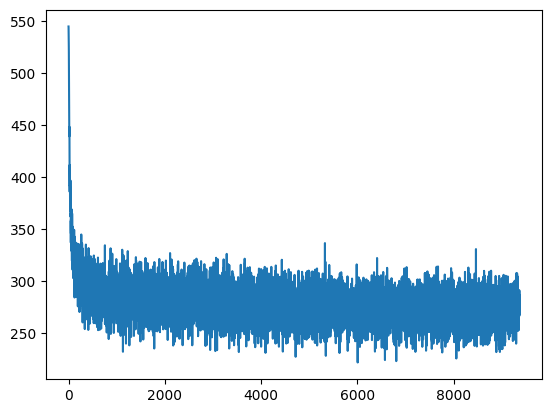

In [30]:
import matplotlib.pyplot as plt
plt.plot(losses);

### Image generation

We can test the decoder with random samples from the prior distribution of $z$. You may run the following cell several times through ctrl-enter.

Note that after the decoder pass, instead of generating a samples from the factorized Bernoulli observation model (which would generate values in $\{0,1\}^{28 \times 28}$, we rather interpret the parameter of the distribution which takes values in $]0,1[^{28 \times 28}$ as the pixel value directly.

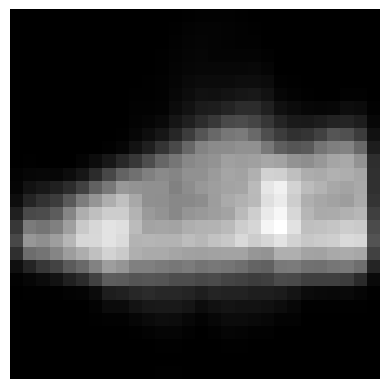

In [31]:
rand_key, key = random.split(key)
params = get_params(opt_state)
params_dec = params[3:]
z = random.normal(key, shape=(1,latent_dim))
generated = decoder_fn(params_dec, z)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

### 2D plot of the image classes in the latent space

We can also use the encoder to set the visualize the distribution of the test set in the 2D latent space of the VAE model. In the following the colors show the true class labels from the test samples.

Note that the VAE is an unsupervised model: it did not use any label information during training. However we can observe that the 2D latent space is largely structured around the categories of images used in the training set.

We will also compare the latent space with a PCA decomposition

In [32]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [33]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train_standard)
encoded_pca_x=pca.transform(x_test_standard)

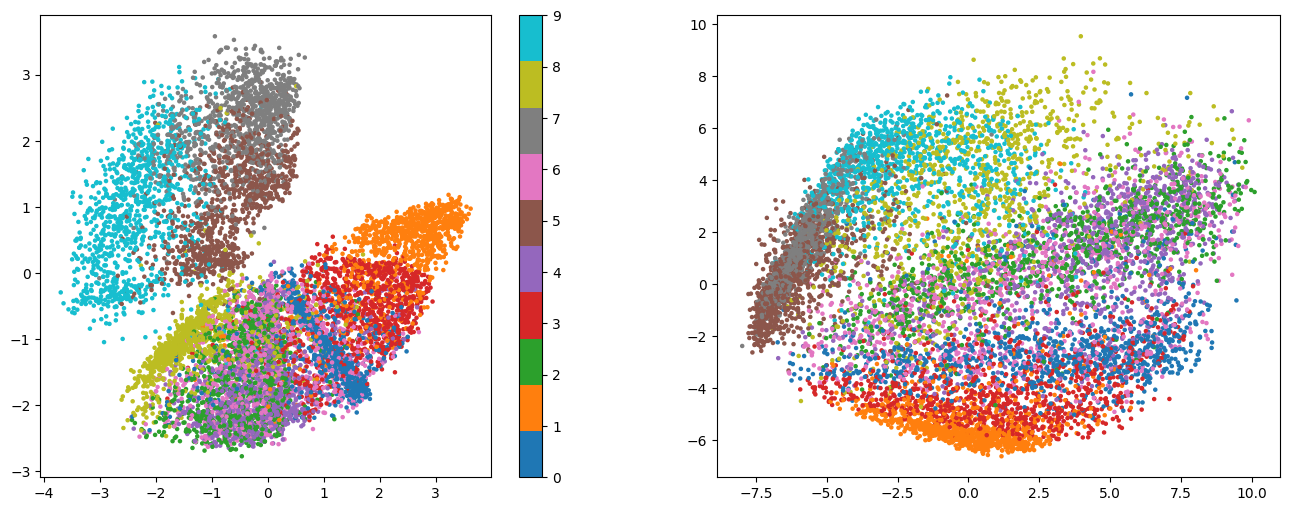

In [34]:
x_test_encoded = encoder_fn(params[0:3], x_test_standard)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10, s=5)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.subplot(1, 2, 2)
plt.scatter(encoded_pca_x[:, 0], encoded_pca_x[:, 1], c=y_test,
            cmap=plt.cm.tab10, s=5)
plt.show()

### How well does the model reconstruct test examples?

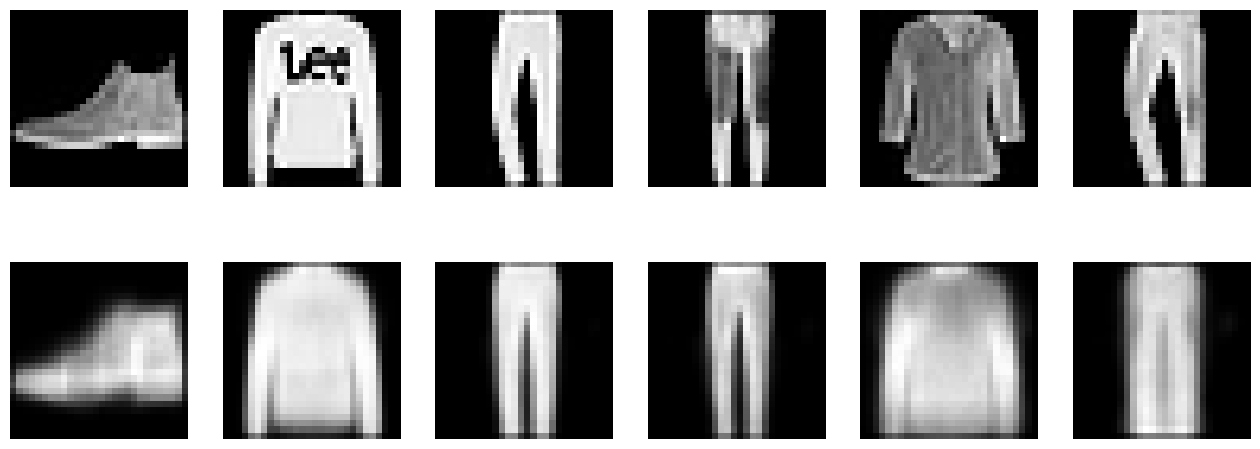

In [35]:
reconstructed_samples = decoder_fn(params[3:], x_test_encoded[0:6,0:2])
plt.figure(figsize=(16, 6))
for i in range(0, 6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_test[i], cmap="gray")
    plt.axis("off")
for i in range(6, 12):
    plt.subplot(2, 6, i + 1)
    img = reconstructed_samples[i - 6].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.show()

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

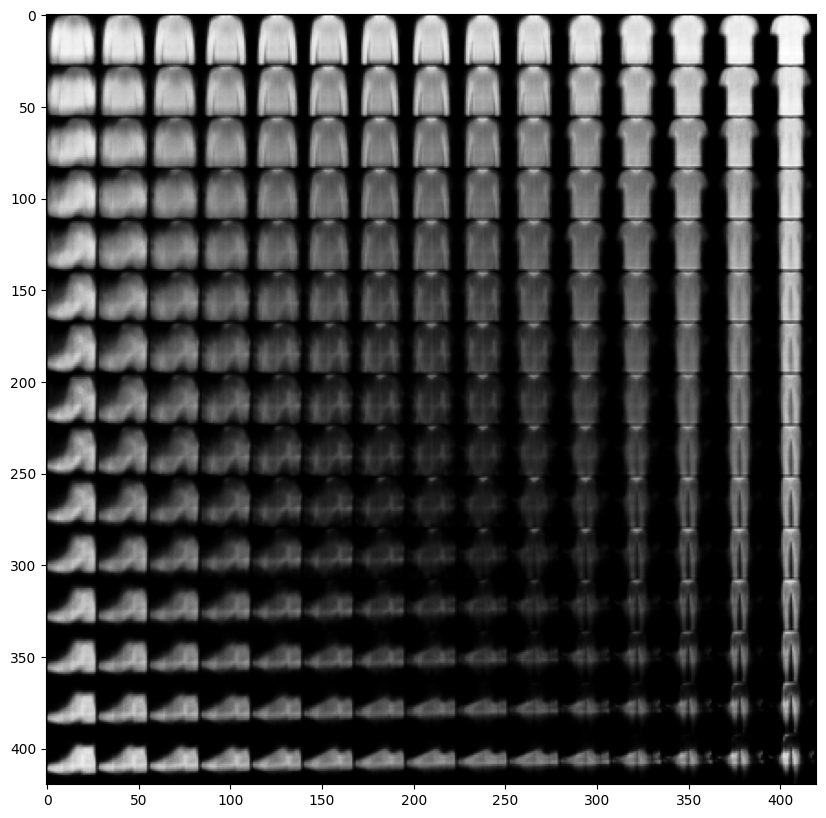

In [36]:
n = 15  # figure with 15x15 panels
image_size = 28
figure = np.zeros((image_size * n, image_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_fn(params[3:], z_sample)
        image = x_decoded[0].reshape(image_size, image_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## <font color=darkred>Detect anomalies in time series (from Keras)</font>

In [37]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [38]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [39]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


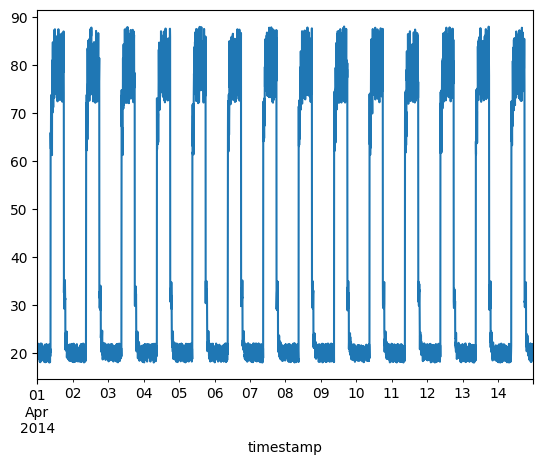

In [40]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

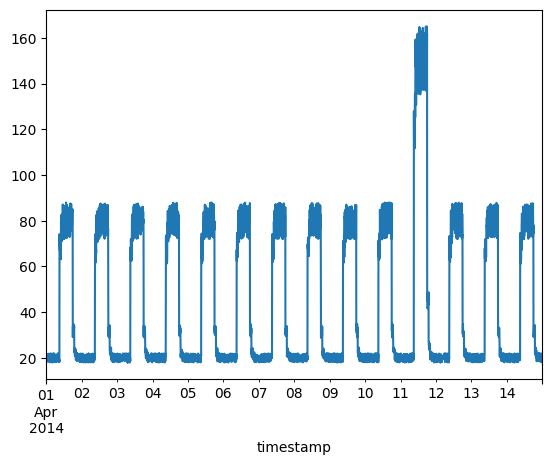

In [41]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [42]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
# One value for every 5 mins for 14 days.

Number of training samples: 4032


In [43]:
TIME_STEPS = 288
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [44]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTr  (None, 144, 16)           1808      
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 288, 32)           3616      
 Transpose)                                             

In [45]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 73ms/step - loss: 0.6053 - val_loss: 0.0724
Epoch 2/50
27/27 [==============================] - 2s 57ms/step - loss: 0.0903 - val_loss: 0.0415
Epoch 3/50
27/27 [==============================] - 2s 58ms/step - loss: 0.0608 - val_loss: 0.0359
Epoch 4/50
27/27 [==============================] - 2s 62ms/step - loss: 0.0500 - val_loss: 0.0319
Epoch 5/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0434 - val_loss: 0.0285
Epoch 6/50
27/27 [==============================] - 2s 71ms/step - loss: 0.0387 - val_loss: 0.0262
Epoch 7/50
27/27 [==============================] - 2s 57ms/step - loss: 0.0349 - val_loss: 0.0239
Epoch 8/50
27/27 [==============================] - 2s 58ms/step - loss: 0.0318 - val_loss: 0.0235
Epoch 9/50
27/27 [==============================] - 2s 57ms/step - loss: 0.0295 - val_loss: 0.0227
Epoch 10/50
27/27 [==============================] - 2s 62ms/step - loss: 0.0275 - val_loss: 0.0224
Epoch 11/

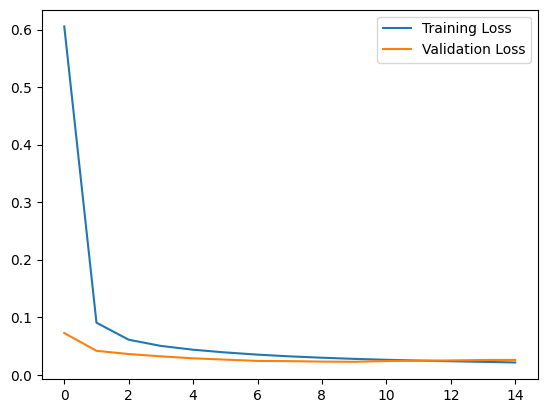

In [46]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 [==============================] - 1s 6ms/step


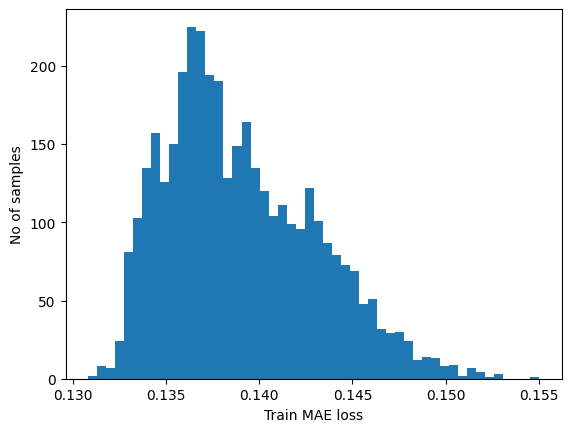

Reconstruction error threshold:  0.15502092895531203


In [47]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

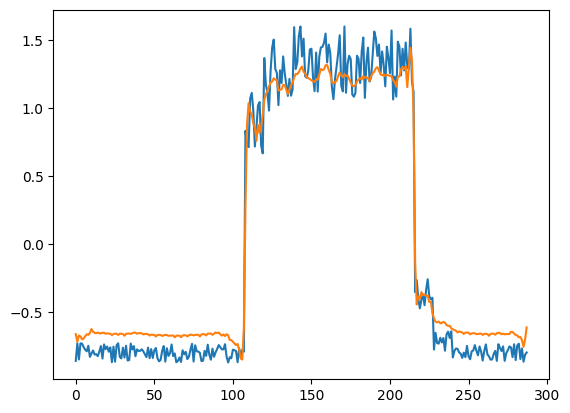

In [48]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()